### Off Ball Runs

In this project you are asked to analyse the attacking run patterns in the Champions League final 2023. Investigate the types of runs made by players during possession chains that entered the final third.
- Create code which plots all runs of a selected player in order to get an idea of the runs they make. 

- Characterise the average run direction and the variation in the player's run direction with a single metric. 

Write a one page report explaining the runs of a specific player in the final.

#### 1. Model Data for attacking runs during possession chains entering the final third

According to the help session, not necessary to merge DF runs and events together in order to get this information. Can instead look at runs that ended in the final third, and had a shot at the end .

Only look at runs where the same team are in possession (not defensive runs)
Create coordinates according to 68*105 --> these are important for metric calculation

In [1]:
import os

import pandas as pd
from matplotlib import pyplot as plt
from mplsoccer import Pitch

In [2]:
pwd

'/Users/jamesdavies/soccermatics/Assignment_3'

In [3]:
cd ~

/Users/jamesdavies


In [4]:
cd soccermatics

/Users/jamesdavies/soccermatics


In [5]:
# CL Finals
match_id = 18768058

# Load pre-generated "runs" data
df_runs = pd.read_parquet(f"data/tracking_data/{match_id}_runs.parquet")
# Load wyscout event data - Coordinates are transformed to opta
df_events = pd.read_parquet(f"data/tracking_data/{match_id}_stories.parquet")
pd.set_option('display.max_columns', None)

In [6]:
df_runs[df_runs.approx_time_start >= 287000.0].sort_values(by='approx_time_start').head(60)
#df_runs[df_runs.xGRun > 0][['approx_time_start', 'approx_time_end']].sort_values(by='approx_time_start').head(60)

,player_id,jersey,team,frame_start,frame_end,start_x,start_y,end_x,end_y,max_speed,avg_speed,player,period,time_start,time_end,team_name,attacking_right,wy_player_id,team_id,approx_time_start,approx_time_end,Forward runs,Distance,Runs into box,xGRun,In possession runs,possession_id,Target
329,home_team_player_8,8,home_team,7175,7282,64.021453,74.604271,86.379697,50.244356,26.485672,19.944320,İlkay Gündoğan,1,04:47.000000,04:51.280000,Manchester City,away_team,14808,1625,287000.0,291280.0,True,28.731874,True,0.0615,True,1670470679,True
669,away_team_player_77,77,away_team,7187,7265,25.127353,7.091601,15.777377,31.771771,24.224580,19.868804,Marcelo Brozović,1,04:47.480000,04:50.600000,Inter,away_team,69968,3161,287480.0,290600.0,False,19.443139,False,0.0000,False,1670470679,False
521,away_team_player_20,20,away_team,7192,7281,27.804578,16.785606,13.633684,48.529549,30.474313,19.856074,Hakan Çalhanoğlu,1,04:47.680000,04:51.240000,Inter,away_team,15524,3161,287680.0,291240.0,False,26.217322,False,0.0000,False,1670470679,False
475,away_team_player_2,2,away_team,7210,7255,21.291703,27.270077,13.503894,38.169767,23.292554,19.952712,Denzel Dumfries,1,04:48.400000,04:50.200000,Inter,away_team,330003,3161,288400.0,290200.0,False,11.036358,False,0.0000,False,1670470679,False
114,home_team_player_20,20,home_team,7215,7258,86.875160,37.111471,91.451256,23.465830,23.230613,19.989182,Bernardo Silva,2,04:48.600000,04:50.320000,Manchester City,home_team,265673,1625,288600.0,290320.0,False,10.449286,False,0.0000,False,-1,False
1,home_team_player_10,10,home_team,7216,7250,78.752550,74.942682,84.251781,66.981610,21.529320,19.820071,Jack Grealish,1,04:48.640000,04:50.000000,Manchester City,away_team,11051,1625,288640.0,290000.0,True,7.915024,True,0.0615,True,1670470679,False
541,away_team_player_20,20,away_team,7251,7291,25.338247,44.924582,17.800429,51.773715,21.234238,19.820398,Hakan Çalhanoğlu,2,04:50.040000,04:51.640000,Inter,home_team,15524,3161,290040.0,291640.0,False,9.183360,False,0.0000,False,-1,False
624,away_team_player_32,32,away_team,7272,7367,29.081283,96.960530,10.095273,75.467941,26.397092,19.928262,Federico Dimarco,2,04:50.880000,04:54.680000,Inter,home_team,239291,3161,290880.0,294680.0,False,24.718691,False,0.0000,False,1670469785,False
660,away_team_player_36,36,away_team,7277,7338,23.608490,18.221365,12.849518,32.448662,23.034250,19.895568,Matteo Darmian,2,04:51.080000,04:53.520000,Inter,home_team,21095,3161,291080.0,293520.0,False,14.873385,False,0.0000,False,-1,False
72,home_team_player_17,17,home_team,7438,7524,76.865129,30.024537,97.555479,22.473997,30.893718,19.909490,Kevin De Bruyne,1,04:57.520000,05:00.960000,Manchester City,away_team,38021,1625,297520.0,300960.0,True,22.323341,True,0.0615,True,1670470679,False


In [35]:
#Filter for runs made when a player's team is in possession
#Also filter for runs finishing within the final third, as we are interested in attacking runs

pitch_length = 105
pitch_width = 68


def transform_x_coordinates(x):
    return (x /  100) * pitch_length


def transform_y_coordinates(x):
    return (x / 100) * pitch_width

df_runs['start_x_norm'] = transform_x_coordinates(df_runs['start_x'])
df_runs['start_y_norm'] = transform_y_coordinates(df_runs['start_y'])
df_runs['end_x_norm'] = transform_x_coordinates(df_runs['end_x'])
df_runs['end_y_norm'] = transform_y_coordinates(df_runs['end_y'])

possesion_chain_runs = df_runs[df_runs.possession_id != -1]
final_third_runs = possesion_chain_runs[possesion_chain_runs['end_x'] >= 100*(2/3)]
#filter for forward runs only
forward_final_third_runs = final_third_runs #final_third_runs[final_third_runs.end_x > final_third_runs.start_x]
#final_third_runs = possesion_chain_runs 

In [36]:
df_runs.player.unique()

array(['Jack Grealish', 'Rodri', 'Kevin De Bruyne', 'Bernardo Silva',
       'Manuel Akanji', 'Rúben Dias', 'Phil Foden', 'John Stones',
       'Nathan Aké', 'İlkay Gündoğan', 'Erling Haaland', 'Kyle Walker',
       'Lautaro Martínez', 'Francesco Acerbi', 'Denzel Dumfries',
       'Hakan Çalhanoğlu', 'Nicolò Barella', 'Federico Dimarco',
       'Matteo Darmian', 'Marcelo Brozović', 'Edin Džeko',
       'Alessandro Bastoni', 'Raoul Bellanova', 'Henrikh Mkhitaryan',
       'André Onana', "Danilo D'Ambrosio", 'Robin Gosens',
       'Romelu Lukaku'], dtype=object)

#### 2. Plot runs of Selected Player
Bernardo Silva and Jack Grealish

Hypothesis: Silva and Grealish were both playing on the 'wings' for Man City in this game, although neither player is a natural wide player. I want to investigate the types of runs they made in the build up to shots. In terms of run variation, I want to look at city midfielders and strikers, and compare them as a whole.

I'm interested about the specific roles they had within the team. Were they supposed to hold their positions out wide or were did they have freedom to move into different spaces.

In [37]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch  # Ensure mplsoccer is installed
import numpy as np

def plot_player_runs_in_final_third(final_third_runs, player_name, df_events, visualize_passing_chain=False):
    """
    Plots the runs of a specified player in the final third, including average displacement and standard deviation.
    
    Parameters:
        final_third_runs (DataFrame): DataFrame containing run data.
        player_name (str): The name of the player whose runs are to be plotted.
        df_events (DataFrame): DataFrame containing event data for possession visualization.
        visualize_passing_chain (bool): Flag to visualize passing chains if required.
    """
    
    # Filter for player's runs
    player_runs = final_third_runs[final_third_runs['player'] == player_name]
    
    if player_runs.empty:
        print(f"No runs found for player: {player_name}")
        return

    # Compute displacement in X and Y directions for each run
    player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
    player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']
    
    # Calculate average displacement (run direction) and standard deviation for X and Y
    avg_displacement_x = player_runs['displacement_x'].mean()
    avg_displacement_y = player_runs['displacement_y'].mean()
    std_displacement_x = player_runs['displacement_x'].std()
    std_displacement_y = player_runs['displacement_y'].std()

    # Calculate the angle of the average displacement (in degrees)
    avg_angle = np.degrees(np.arctan2(avg_displacement_y, avg_displacement_x))

    # Normalize the angle to ensure consistency relative to the goal direction
    if avg_angle < 0:
        avg_angle += 360  # Adjust negative angles

    # Normalize to a range of 0° to 180° (toward the goal)
    if avg_angle > 180:
        avg_angle = 360 - avg_angle  # Reflect angles to the other side

    # Plot all runs for the player
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
    
    # Correct pitch dimensions: 105 meters long and 68 meters wide
    pitch = Pitch(pitch_type="opta",
                  goal_type='box',
                  pitch_color="w",
                  linewidth=1,
                  spot_scale=0,
                  line_color="k",
                  line_zorder=1,
                  pitch_length=100,  # Correct pitch length
                  pitch_width=100)    # Correct pitch width

    pitch.draw(ax)

    # Define a fixed color for all runs
    run_color = 'blue'

    # Plot all runs for the player
    for idx, row in player_runs.iterrows():
        # Visualize runs with a fixed color
        pitch.arrows(row['start_x'], row['start_y'],
                     row['end_x'], row['end_y'],
                     width=1.8,
                     headwidth=3, headlength=3, headaxislength=2,
                     color=run_color,
                     edgecolor="k" if row['xGRun']>0.5 else run_color,
                     linewidth=1 if row['xGRun']>0.5 else 0,
                     alpha=0.8,
                     zorder=3,
                     label=row['player'],
                     ax=ax)

        # Visualize possession chain if required
        if visualize_passing_chain:
            df_possession = df_events[(df_events['possession_id'] == row['possession_id']) & 
                                      (df_events['possession_team_id'] == row['team_id'])]

    # Add title
    possession_start_time = player_runs['time_start'].min()[0:5]
    possession_end_time = player_runs['time_end'].max()[0:5]
    team_name = player_runs.iloc[0]['team_name']
    ax.set_title(f"{team_name} runs into final third by {player_name}")

    # Add the label for average displacement and variation (std deviation)
    avg_displacement_label = (f"Avg Displacement: (Angle: {avg_angle:.2f}°)\n"
                              f"Std Dev: (X: {std_displacement_x:.2f}, Y: {std_displacement_y:.2f})")
    ax.text(1.02, 0.5, avg_displacement_label, transform=ax.transAxes, fontsize=10, verticalalignment='center')

    # Display the plot
    plt.show()


/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/1259336574.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/1259336574.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


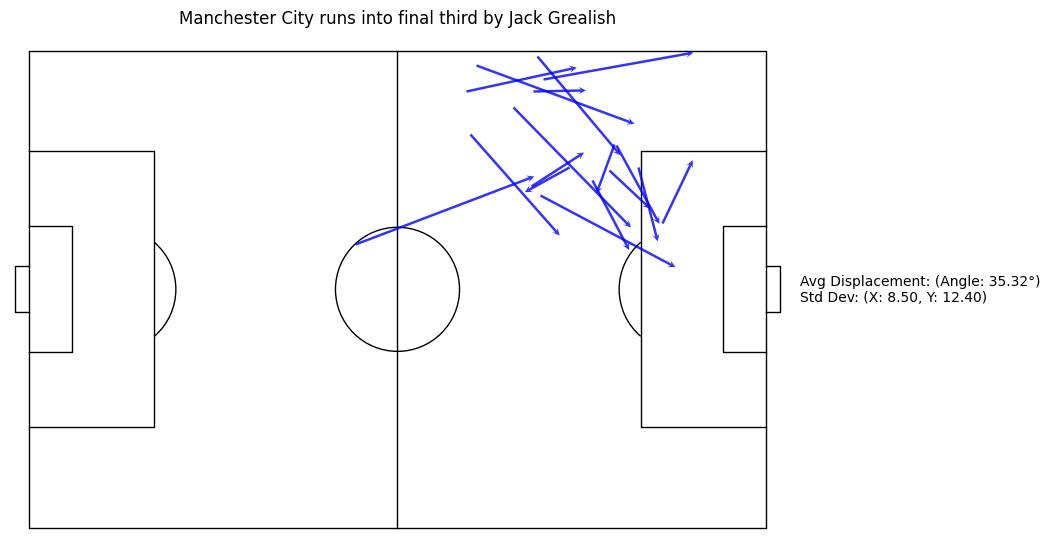

In [38]:
plot_player_runs_in_final_third(forward_final_third_runs, 'Jack Grealish', df_events, visualize_passing_chain=True)

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/1259336574.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/1259336574.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


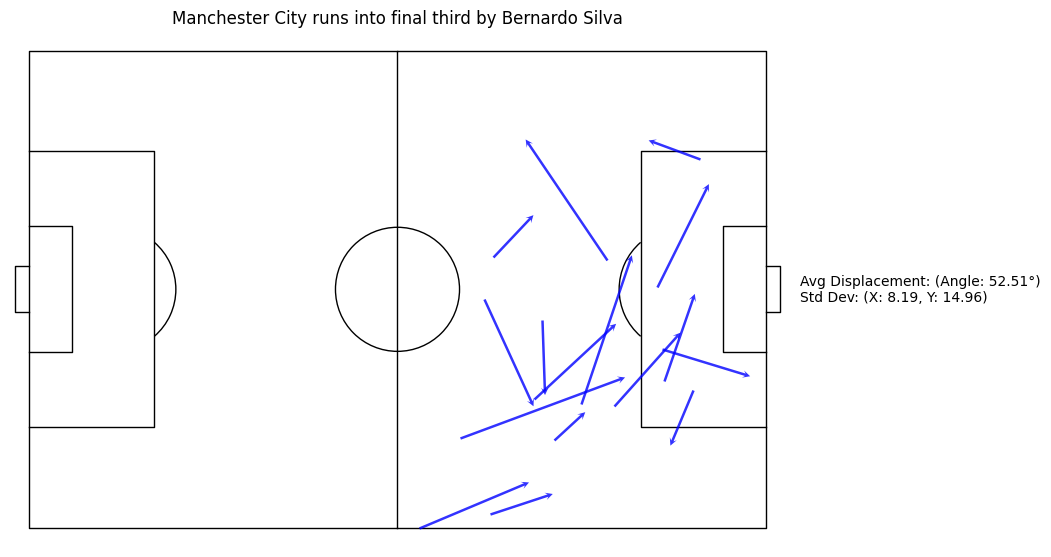

In [39]:
plot_player_runs_in_final_third(forward_final_third_runs, 'Bernardo Silva', df_events, visualize_passing_chain=True)

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/1259336574.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/1259336574.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


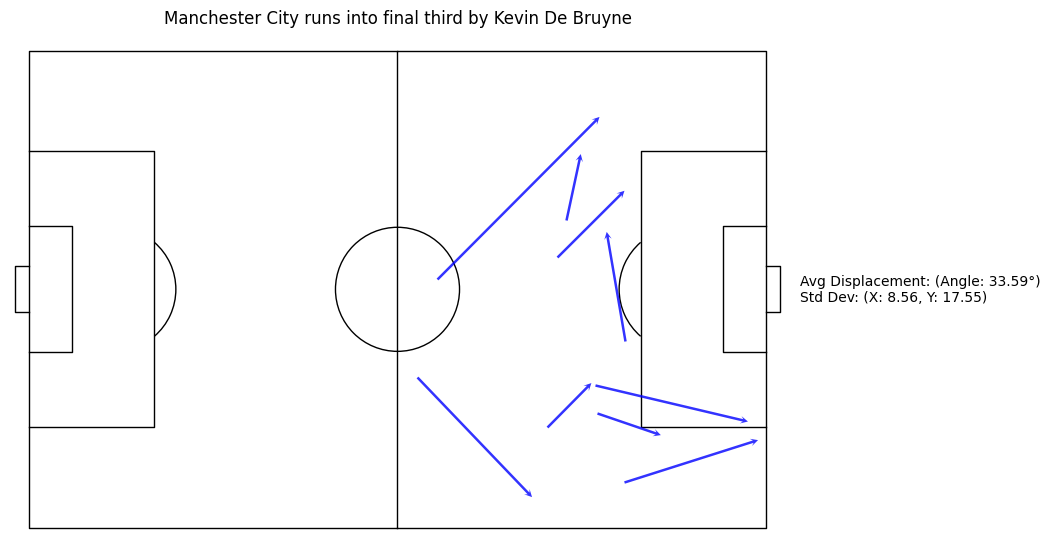

In [33]:
plot_player_runs_in_final_third(forward_final_third_runs, 'Kevin De Bruyne', df_events, visualize_passing_chain=True)

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/1259336574.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/1259336574.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


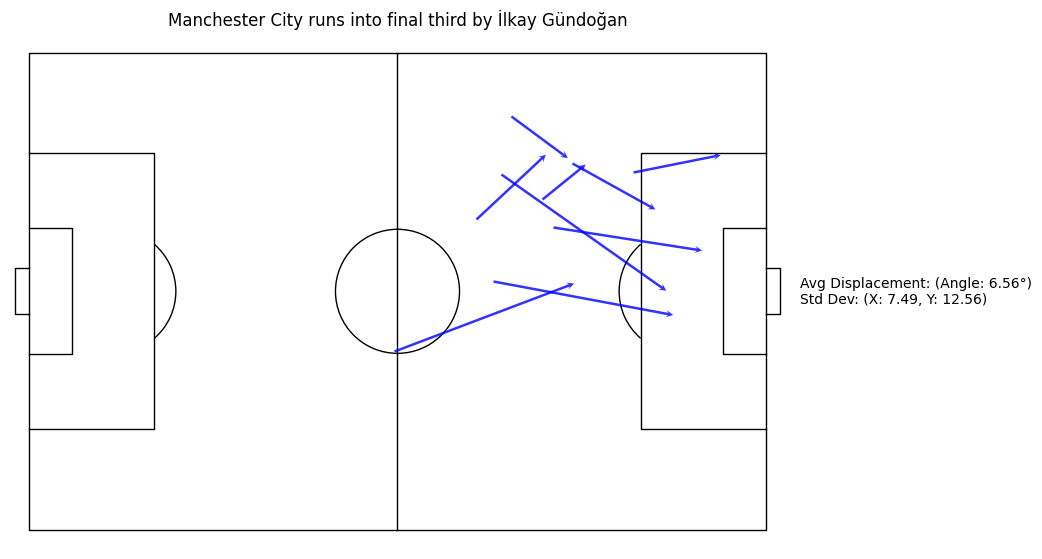

In [34]:
plot_player_runs_in_final_third(forward_final_third_runs, 'İlkay Gündoğan', df_events, visualize_passing_chain=True)

#### 3. Avg Run direction and variation in player's run direction

Lateral movement / Run Length: Measures the extent to which the run is directly forward and also if the run is towards the touchline or infield. 

Edge Case: A player begins movement towards the centre line and keeps going (past the centre line) to the touchline. In this case, we still consider.

Advantages: Two attacking runs towards the opponents goal (increase in x-axis) will look similar. 
Disadvantages: Two runs either towards the centre or towards the sideline will look the same if they are on the same angle, irrespective of whether they are going towards their goal or their opponents goal. 

In [41]:
import numpy as np

def calculate_lateral_movement_per_length(df_runs, centerline=34):
    # Step 1: Calculate the run's length (Euclidean distance)
    df_runs['run_length'] = np.sqrt((df_runs['end_x_norm'] - df_runs['start_x_norm'])**2 + 
                                     (df_runs['end_y_norm'] - df_runs['start_y_norm'])**2)

    # Initialize lateral movement and lengths before and after the centerline
    lateral_movements = []
    length_before_centerline = []
    length_after_centerline = []

    for _, row in df_runs.iterrows():
        start_y = row['start_y_norm']
        end_y = row['end_y_norm']

        # Calculate distance before and after crossing the centerline
        if start_y < centerline and end_y < centerline:
            # Entire run is below the centerline
            pre_cross_length = np.sqrt((row['end_x_norm'] - row['start_x_norm'])**2 + (row['end_y_norm'] - row['start_y_norm'])**2)
            post_cross_length = 0
        elif start_y >= centerline and end_y >= centerline:
            # Entire run is above the centerline
            pre_cross_length = 0
            post_cross_length = np.sqrt((row['end_x_norm'] - row['start_x_norm'])**2 + (row['end_y_norm'] - row['start_y_norm'])**2)
        else:
            # Run crosses the centerline
            # Find intersection with centerline (x-value)
            slope = (end_y - start_y) / (row['end_x_norm'] - row['start_x_norm']) if row['end_x_norm'] != row['start_x_norm'] else 0
            intercept = start_y - slope * row['start_x_norm']
            centerline_x = (centerline - intercept) / slope if slope != 0 else row['start_x_norm']
            
            # Calculate lengths
            pre_cross_length = np.sqrt((centerline_x - row['start_x_norm'])**2 + (centerline - start_y)**2)
            post_cross_length = np.sqrt((row['end_x_norm'] - centerline_x)**2 + (row['end_y_norm'] - centerline)**2)

        # Total run length
        total_length = pre_cross_length + post_cross_length
        lateral_movement = (end_y - start_y)

        # Determine classification based on the lengths
        if pre_cross_length > total_length / 2:
            # More than half is before the centerline (run to the middle)
            lateral_movement = -(end_y - start_y)  # Consider this as negative movement
        else:
            # More than half is after the centerline (run out wide)
            lateral_movement = end_y - start_y  # Positive movement

        lateral_movements.append(lateral_movement)
        length_before_centerline.append(pre_cross_length)
        length_after_centerline.append(post_cross_length)

    # Add calculated values to the DataFrame
    df_runs['lateral_movement'] = lateral_movements
    df_runs['length_before_centerline'] = length_before_centerline
    df_runs['length_after_centerline'] = length_after_centerline
    
    # Step 3: Calculate lateral movement per unit of run length
    df_runs['lateral_movement_per_length'] = df_runs['lateral_movement'] / df_runs['run_length']
    
    return df_runs

# Apply the metric calculation to your runs DataFrame
final_third_runs_with_metric = calculate_lateral_movement_per_length(forward_final_third_runs)

# Now you can inspect or rank the runs based on the 'lateral_movement_per_length'
final_third_runs_with_metric[['player', 'lateral_movement', 'run_length', 'lateral_movement_per_length']]


/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/229756065.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs['run_length'] = np.sqrt((df_runs['end_x_norm'] - df_runs['start_x_norm'])**2 +
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/229756065.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs['lateral_movement'] = lateral_movements
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/229756065.py:55: SettingWithCopyWarning: 
A value is trying 

,player,lateral_movement,run_length,lateral_movement_per_length
1,Jack Grealish,-5.413529,7.915024,-0.683956
2,Jack Grealish,-14.394281,19.201143,-0.749658
6,Jack Grealish,-8.307048,23.986090,-0.346328
7,Jack Grealish,-14.056455,18.353956,-0.765854
9,Jack Grealish,3.403433,16.078416,0.211677
...,...,...,...,...
796,Romelu Lukaku,-11.000251,20.978301,-0.524363
797,Romelu Lukaku,1.133082,16.132112,0.070238
798,Romelu Lukaku,-3.445393,23.559729,-0.146241
803,Romelu Lukaku,-2.030187,22.144112,-0.091681


In [42]:
final_third_runs_with_metric[final_third_runs_with_metric.player == 'Bernardo Silva']

,player_id,jersey,team,frame_start,frame_end,start_x,start_y,end_x,end_y,max_speed,avg_speed,player,period,time_start,time_end,team_name,attacking_right,wy_player_id,team_id,approx_time_start,approx_time_end,Forward runs,Distance,Runs into box,xGRun,In possession runs,possession_id,Target,start_x_norm,start_y_norm,end_x_norm,end_y_norm,run_length,lateral_movement,length_before_centerline,length_after_centerline,lateral_movement_per_length
88,home_team_player_20,20,home_team,3534,3615,74.859237,25.975266,81.698532,57.241351,27.751611,19.945613,Bernardo Silva,1,02:21.360000,02:24.600000,Manchester City,away_team,265673,1625,141360.0,144600.0,False,22.440989,False,0.0000,False,1670469663,False,78.602199,17.663181,85.783458,38.924119,22.440989,-21.260938,17.243566,5.197423,-0.947415
89,home_team_player_20,20,home_team,4931,4984,86.168929,30.758927,90.280461,49.118473,24.104225,19.871952,Bernardo Silva,1,03:17.240000,03:19.360000,Manchester City,away_team,265673,1625,197240.0,199360.0,False,13.209842,False,0.0000,False,1670469676,False,90.477375,20.916070,94.794484,33.400561,13.209842,-12.484491,13.209842,0.000000,-0.945090
90,home_team_player_20,20,home_team,10967,11032,68.558702,27.002839,79.635054,42.867405,23.851895,19.850726,Bernardo Silva,1,07:18.680000,07:21.280000,Manchester City,away_team,265673,1625,438680.0,441280.0,False,15.863157,False,0.0000,False,1670469768,False,71.986637,18.361930,83.616807,29.149835,15.863157,-10.787905,15.863157,0.000000,-0.680060
95,home_team_player_20,20,home_team,31280,31340,85.263369,50.417695,92.237157,72.088270,27.569364,19.964719,Bernardo Silva,1,20:51.200000,20:53.600000,Manchester City,away_team,265673,1625,1251200.0,1253600.0,False,16.455033,False,0.0000,False,1670470180,False,89.526537,34.284033,96.849015,49.020023,16.455033,14.735991,0.000000,16.455033,0.895531
96,home_team_player_20,20,home_team,31359,31384,90.990749,77.226192,83.951678,81.231005,37.358895,20.045786,Bernardo Silva,1,20:54.360000,20:55.360000,Manchester City,away_team,265673,1625,1254360.0,1255360.0,False,7.876766,False,0.0000,False,1670470180,False,95.540286,52.513811,88.149262,55.237084,7.876766,2.723273,0.000000,7.876766,0.345735
99,home_team_player_20,20,home_team,33208,33291,78.492675,56.189253,67.384256,81.556852,24.238692,19.864400,Bernardo Silva,1,22:08.320000,22:11.640000,Manchester City,away_team,265673,1625,1328320.0,1331640.0,False,20.823222,False,0.0000,False,1670470234,False,82.417309,38.208692,70.753469,55.458660,20.823222,17.249968,0.000000,20.823222,0.828401
103,home_team_player_20,20,home_team,40518,40554,90.162075,28.899727,87.025904,17.344313,22.027951,19.849961,Bernardo Silva,1,27:00.720000,27:02.160000,Manchester City,away_team,265673,1625,1620720.0,1622160.0,False,8.519793,False,0.0000,True,1670471140,True,94.670178,19.651814,91.377199,11.794133,8.519793,7.857682,8.519793,0.000000,0.922286
105,home_team_player_20,20,home_team,50950,50990,62.602136,2.834451,71.054175,7.136995,21.669109,19.912471,Bernardo Silva,1,33:58.000000,33:59.600000,Manchester City,away_team,265673,1625,2038000.0,2039600.0,True,9.344472,False,0.0000,True,1670471831,False,65.732243,1.927427,74.606884,4.853156,9.344472,-2.925730,9.344472,0.000000,-0.313097
109,home_team_player_20,20,home_team,58018,58074,79.345989,25.529552,88.302094,41.003580,24.868526,19.966385,Bernardo Silva,1,38:40.720000,38:42.960000,Manchester City,away_team,265673,1625,2320720.0,2322960.0,False,14.112162,False,0.0000,False,1670470592,False,83.313289,17.360096,92.717198,27.882434,14.112162,-10.522339,14.112162,0.000000,-0.745622
124,home_team_player_20,20,home_team,24048,24114,52.885299,0.000000,67.748694,9.656458,25.286285,19.858277,Bernardo Silva,2,16:01.920000,16:04.560000,Manchester City,home_team,265673,1625,961920.0,964560.0,True,16.931697,False,0.0000,True,1670470020,False,55.529564,0.000000,71.136129,6.566392,16.931697,-6.566392,16.931697,0.000000,-0.387817


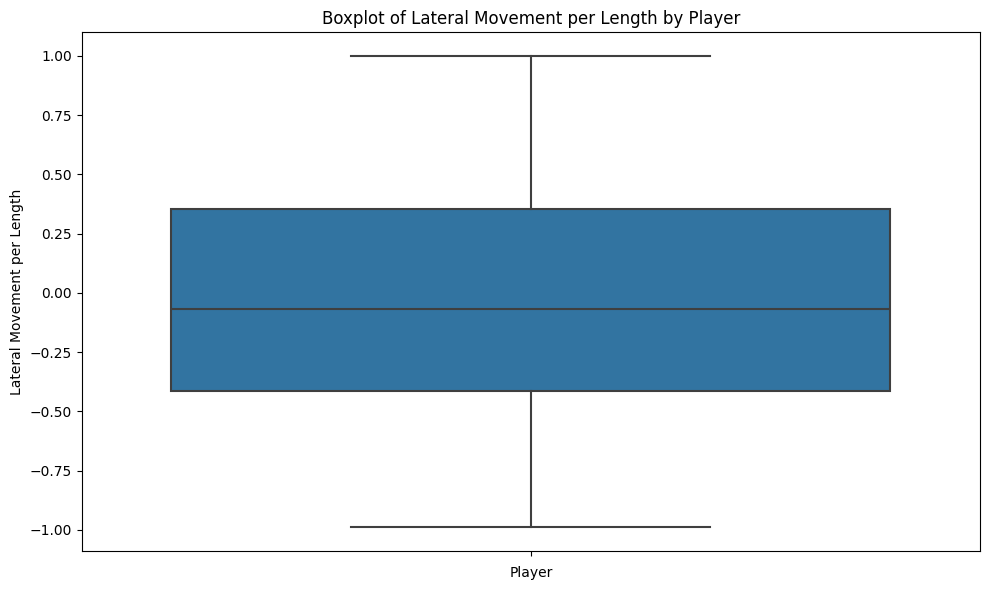

In [43]:
import seaborn as sns

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y='lateral_movement_per_length', data=final_third_runs_with_metric)

# Add title and labels
plt.title('Boxplot of Lateral Movement per Length by Player')
plt.xlabel('Player')
plt.ylabel('Lateral Movement per Length')

# Show the plot
plt.tight_layout()
plt.show()

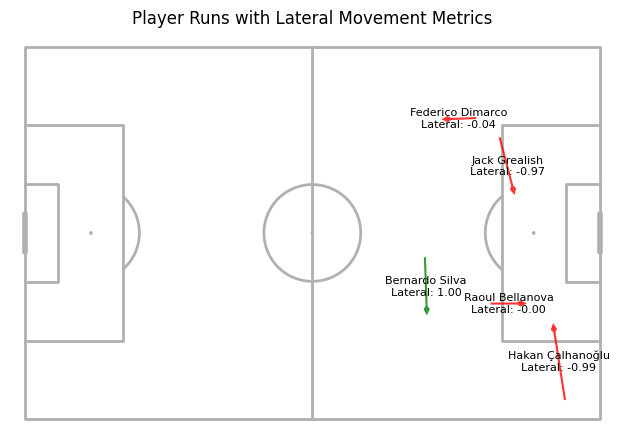

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

def visualize_runs_on_pitch(df_runs):
    # Create the pitch
    pitch = Pitch(pitch_type='opta', pitch_color='white', linewidth=2, pitch_length=105, pitch_width=68)
    fig, ax = pitch.draw()

    # Loop through each run and plot it
    for idx, row in df_runs.iterrows():
        # Determine color based on lateral movement per length
        if row['lateral_movement_per_length'] > 0:
            color = 'green'  # Moving towards touchline
        elif row['lateral_movement_per_length'] < 0:
            color = 'red'  # Moving towards centerline
        else:
            color = 'blue'  # Neutral movement

        # Plot the run as an arrow
        pitch.arrows(row['start_x'], row['start_y'],
                     row['end_x'], row['end_y'],
                     width=1.5,
                     headwidth=3, headlength=3,
                     color=color,
                     alpha=0.8,
                     label=row['player'],
                     ax=ax)

        # Annotate the run with its length and lateral movement per length
        ax.text((row['start_x'] + row['end_x']) / 2,
                 (row['start_y'] + row['end_y']) / 2,
                 f"{row['player']}\nLateral: {row['lateral_movement_per_length']:.2f}",
                 fontsize=8,
                 ha='center', va='center')

    # Set title
    ax.set_title('Player Runs with Lateral Movement Metrics')
    plt.show()

# Example usage with df_runs
# Assuming df_runs is your DataFrame containing the runs with the necessary columns
# df_runs = calculate_lateral_movement_per_length(df_runs)  # Calculate metrics if not done
visualize_runs_on_pitch(final_third_runs_with_metric.loc[[134, 528, 765, 24, 630]])

In [71]:
final_third_runs_with_metric[(final_third_runs_with_metric.lateral_movement_per_length < 0.1)].sort_values(by='lateral_movement_per_length', ascending=False).head(50)
#134
#528
#765
#630

,player_id,jersey,team,frame_start,frame_end,start_x,start_y,end_x,end_y,max_speed,avg_speed,player,period,time_start,time_end,team_name,attacking_right,wy_player_id,team_id,approx_time_start,approx_time_end,Forward runs,Distance,Runs into box,xGRun,In possession runs,possession_id,Target,start_x_norm,start_y_norm,end_x_norm,end_y_norm,run_length,lateral_movement,length_before_centerline,length_after_centerline,lateral_movement_per_length
539,away_team_player_20,20,away_team,1576,1699,44.730566,78.139488,77.018114,82.066621,27.108969,19.857958,Hakan Çalhanoğlu,2,01:03.040000,01:07.960000,Inter,home_team,15524,3161,63040.0,67960.0,False,34.006938,False,0.0000,False,1670469726,False,46.967094,53.134852,80.869019,55.805302,34.006938,2.670450,0.000000,34.006938,0.078527
797,away_team_player_90,90,away_team,41415,41480,66.213685,33.747593,81.539657,32.081295,23.661843,19.865534,Romelu Lukaku,2,27:36.600000,27:39.200000,Inter,home_team,7905,3161,1656600.0,1659200.0,True,16.132112,False,0.2330,True,1670471559,True,69.524369,22.948363,85.616640,21.815281,16.132112,1.133082,16.132112,0.000000,0.070238
523,away_team_player_20,20,away_team,8472,8545,50.021730,94.224785,66.800991,95.992667,23.881886,19.801771,Hakan Çalhanoğlu,1,05:38.880000,05:41.800000,Inter,away_team,15524,3161,338880.0,341800.0,True,17.659191,False,0.0000,True,1670469711,False,52.522816,64.072854,70.141041,65.275014,17.659191,1.202160,0.000000,17.659191,0.068076
578,away_team_player_23,23,away_team,872,1066,38.630503,24.669019,83.582036,19.995279,31.580290,19.882066,Nicolò Barella,2,00:34.880000,00:42.640000,Inter,home_team,286223,3161,34880.0,42640.0,True,47.305989,False,0.0000,True,1670470938,False,40.562028,16.774933,87.761138,13.596789,47.305989,3.178143,47.305989,0.000000,0.067183
28,home_team_player_10,10,home_team,52426,52458,68.451330,91.576906,75.569148,91.809802,21.744908,19.936025,Jack Grealish,2,34:57.040000,34:58.320000,Manchester City,home_team,11051,1625,2097040.0,2098320.0,True,7.475386,False,0.0000,True,1670470353,False,71.873896,62.272296,79.347605,62.430665,7.475386,0.158369,0.000000,7.475386,0.021185
192,home_team_player_3,3,home_team,9905,9965,69.937326,7.956820,84.791183,7.560763,25.375913,19.920011,Rúben Dias,2,06:36.200000,06:38.600000,Manchester City,home_team,258154,1625,396200.0,398600.0,True,15.598875,False,0.0000,True,1670469812,False,73.434192,5.410638,89.030742,5.141319,15.598875,0.269319,15.598875,0.000000,0.017265
599,away_team_player_32,32,away_team,19475,19575,45.217284,96.013469,73.732363,96.685297,30.678422,19.876605,Federico Dimarco,1,12:59.000000,13:03.000000,Inter,away_team,239291,3161,779000.0,783000.0,True,29.944318,False,0.0000,True,1670469959,True,47.478148,65.289159,77.418981,65.746002,29.944318,0.456843,0.000000,29.944318,0.015256
500,away_team_player_2,2,away_team,10062,10242,20.273344,31.872250,66.752682,30.882154,29.166610,19.894325,Denzel Dumfries,2,06:42.480000,06:49.680000,Inter,home_team,330003,3161,402480.0,409680.0,True,48.807949,False,0.0000,True,1670471092,False,21.287012,21.673130,70.090317,20.999864,48.807949,0.673266,48.807949,0.000000,0.013794
765,away_team_player_12,12,away_team,73205,73234,80.995964,31.028778,87.292768,31.062614,20.917348,19.869722,Raoul Bellanova,2,01:54.280000,01:55.440000,Inter,home_team,405598,3161,114280.0,115440.0,False,6.611684,False,0.0000,False,1670469726,False,85.045763,21.099569,91.657406,21.122578,6.611684,-0.023009,6.611684,0.000000,-0.003480
249,home_team_player_5,5,home_team,4754,4794,58.442479,22.366740,67.540505,22.473212,22.378435,19.878563,John Stones,1,03:10.160000,03:11.760000,Manchester City,away_team,9380,1625,190160.0,191760.0,False,9.553201,False,0.0000,False,1670469676,False,61.364603,15.209383,70.917530,15.281784,9.553201,-0.072401,9.553201,0.000000,-0.007579


In [53]:
final_third_runs_with_metric.loc[[134, 528, 765, 630]]

,player_id,jersey,team,frame_start,frame_end,start_x,start_y,end_x,end_y,max_speed,avg_speed,player,period,time_start,time_end,team_name,attacking_right,wy_player_id,team_id,approx_time_start,approx_time_end,Forward runs,Distance,Runs into box,xGRun,In possession runs,possession_id,Target,start_x_norm,start_y_norm,end_x_norm,end_y_norm,run_length,lateral_movement,length_before_centerline,length_after_centerline,lateral_movement_per_length
134,home_team_player_20,20,home_team,46815,46860,69.585536,43.481990,69.928800,27.851576,22.167830,19.925956,Bernardo Silva,2,31:12.600000,31:14.400000,Manchester City,home_team,265673,1625,1872600.0,1874400.0,True,10.634791,False,0.0,True,1670470278,False,73.064813,29.567753,73.425240,18.939071,10.634791,10.628682,10.634791,0.000000,0.999426
528,away_team_player_20,20,away_team,21176,21234,93.948361,5.107233,91.863113,25.788223,23.553396,19.900060,Hakan Çalhanoğlu,1,14:07.040000,14:09.360000,Inter,away_team,15524,3161,847040.0,849360.0,False,14.232497,True,0.0,True,1670469981,False,98.645779,3.472919,96.456269,17.535992,14.232497,-14.063073,14.232497,0.000000,-0.988096
765,away_team_player_12,12,away_team,73205,73234,80.995964,31.028778,87.292768,31.062614,20.917348,19.869722,Raoul Bellanova,2,01:54.280000,01:55.440000,Inter,home_team,405598,3161,114280.0,115440.0,False,6.611684,False,0.0,False,1670469726,False,85.045763,21.099569,91.657406,21.122578,6.611684,-0.023009,6.611684,0.000000,-0.003480
630,away_team_player_32,32,away_team,19638,19666,78.504323,80.862173,72.472512,80.516231,20.645232,19.872858,Federico Dimarco,2,13:05.520000,13:06.640000,Inter,home_team,239291,3161,785520.0,786640.0,False,6.337769,False,0.0,False,1670469963,False,82.429539,54.986278,76.096137,54.751037,6.337769,-0.235241,0.000000,6.337769,-0.037117


In [18]:
final_third_runs_with_metric[final_third_runs_with_metric.player == 'Bernardo Silva'].sort_values(by='lateral_movement_per_length', ascending=False)

,player_id,jersey,team,frame_start,frame_end,start_x,start_y,end_x,end_y,max_speed,avg_speed,player,period,time_start,time_end,team_name,attacking_right,wy_player_id,team_id,approx_time_start,approx_time_end,Forward runs,Distance,Runs into box,xGRun,In possession runs,possession_id,Target,start_x_norm,start_y_norm,end_x_norm,end_y_norm,run_length,lateral_movement,length_before_centerline,length_after_centerline,lateral_movement_per_length
134,home_team_player_20,20,home_team,46815,46860,69.585536,43.481990,69.928800,27.851576,22.167830,19.925956,Bernardo Silva,2,31:12.600000,31:14.400000,Manchester City,home_team,265673,1625,1872600.0,1874400.0,True,10.634791,False,0.0000,True,1670470278,False,73.064813,29.567753,73.425240,18.939071,10.634791,10.628682,10.634791,0.000000,0.999426
139,home_team_player_20,20,home_team,66480,66551,61.707631,47.870180,68.358813,25.485862,22.047447,19.819699,Bernardo Silva,2,44:19.200000,44:22.040000,Manchester City,home_team,265673,1625,2659200.0,2662040.0,False,16.746991,False,0.0000,False,1670471751,False,64.793012,32.551722,71.776753,17.330386,16.746991,15.221336,16.746991,0.000000,0.908900
95,home_team_player_20,20,home_team,31280,31340,85.263369,50.417695,92.237157,72.088270,27.569364,19.964719,Bernardo Silva,1,20:51.200000,20:53.600000,Manchester City,away_team,265673,1625,1251200.0,1253600.0,False,16.455033,False,0.0000,False,1670470180,False,89.526537,34.284033,96.849015,49.020023,16.455033,14.735991,0.000000,16.455033,0.895531
136,home_team_player_20,20,home_team,62333,62369,62.967691,56.698267,68.388815,65.573692,21.399176,19.855826,Bernardo Silva,2,41:33.320000,41:34.760000,Manchester City,home_team,265673,1625,2493320.0,2494760.0,False,8.296121,False,0.0000,False,1670471717,False,66.116075,38.554822,71.808256,44.590110,8.296121,6.035289,0.000000,8.296121,0.727483
129,home_team_player_20,20,home_team,33664,33715,85.864477,37.452036,97.760669,31.846275,24.702036,20.038893,Bernardo Silva,2,22:26.560000,22:28.600000,Manchester City,home_team,265673,1625,1346560.0,1348600.0,True,13.059703,False,0.1089,True,1670470110,True,90.157701,25.467384,102.648702,21.655467,13.059703,3.811917,13.059703,0.000000,0.291884
105,home_team_player_20,20,home_team,50950,50990,62.602136,2.834451,71.054175,7.136995,21.669109,19.912471,Bernardo Silva,1,33:58.000000,33:59.600000,Manchester City,away_team,265673,1625,2038000.0,2039600.0,True,9.344472,False,0.0000,True,1670471831,False,65.732243,1.927427,74.606884,4.853156,9.344472,-2.925730,9.344472,0.000000,-0.313097
126,home_team_player_20,20,home_team,27317,27415,58.499822,18.802358,80.837574,31.600677,25.095506,19.816260,Bernardo Silva,2,18:12.680000,18:16.600000,Manchester City,home_team,265673,1625,1092680.0,1096600.0,True,25.017191,False,0.0000,True,1670470065,False,61.424813,12.785604,84.879453,21.488460,25.017191,-8.702857,25.017191,0.000000,-0.347875
124,home_team_player_20,20,home_team,24048,24114,52.885299,0.000000,67.748694,9.656458,25.286285,19.858277,Bernardo Silva,2,16:01.920000,16:04.560000,Manchester City,home_team,265673,1625,961920.0,964560.0,True,16.931697,False,0.0000,True,1670470020,False,55.529564,0.000000,71.136129,6.566392,16.931697,-6.566392,16.931697,0.000000,-0.387817
127,home_team_player_20,20,home_team,31869,31895,71.272099,18.482874,75.448967,24.423454,21.025718,19.911297,Bernardo Silva,2,21:14.760000,21:15.800000,Manchester City,home_team,265673,1625,1274760.0,1275800.0,True,5.962616,False,0.0000,True,1670470110,False,74.835704,12.568354,79.221415,16.607949,5.962616,-4.039594,5.962616,0.000000,-0.677487
90,home_team_player_20,20,home_team,10967,11032,68.558702,27.002839,79.635054,42.867405,23.851895,19.850726,Bernardo Silva,1,07:18.680000,07:21.280000,Manchester City,away_team,265673,1625,438680.0,441280.0,False,15.863157,False,0.0000,False,1670469768,False,71.986637,18.361930,83.616807,29.149835,15.863157,-10.787905,15.863157,0.000000,-0.680060


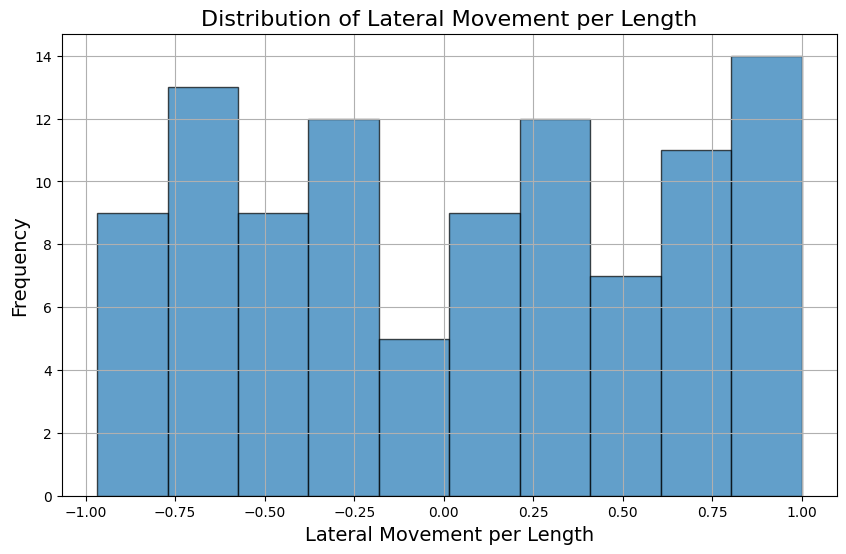

In [76]:
#Plot distribution 
import matplotlib.pyplot as plt

# Plot histogram of lateral movement per length
def plot_histogram(df_runs):
    #df_runs = df_runs[df_runs.player == player]
    plt.figure(figsize=(10, 6))  # Optional: Set figure size
    plt.hist(df_runs['lateral_movement_per_length'], bins=10, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Lateral Movement per Length', fontsize=16)
    plt.xlabel(f'Lateral Movement per Length', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True)  # Optional: Add gridlines for easier readability
    plt.show()


plot_histogram(final_third_runs_with_metric[final_third_runs_with_metric.team_name == 'Manchester City'])
#plot_histogram(final_third_runs_with_metric)

In [84]:
def calculate_player_averages_and_variance(df_runs):
    """
    Calculates the average and variance of lateral movement, lateral movement per length,
    and average start and end coordinates for each player.

    Parameters:
    df_runs (DataFrame): DataFrame containing runs data with player identifiers and metrics.

    Returns:
    DataFrame: A DataFrame containing average values and variances for each player.
    """
    # Ensure the DataFrame has the necessary columns
    required_columns = ['player', 'lateral_movement', 'lateral_movement_per_length', 
                        'start_x', 'start_y', 'end_x', 'end_y']
    for col in required_columns:
        if col not in df_runs.columns:
            raise ValueError(f"Missing required column: {col}")

    df_runs['abs_lateral_movement_per_length'] = abs(df_runs['lateral_movement_per_length'])
    # Custom function to calculate IQR
    def iqr(series):
        return np.percentile(series, 75) - np.percentile(series, 25)

    # Group by player and calculate mean and variance
    player_stats = df_runs.groupby('player').agg(
        avg_lateral_movement=('lateral_movement', 'mean'),
        iqr_lateral_movement=('lateral_movement', iqr), 
        var_lateral_movement=('lateral_movement', 'var'),
        avg_lateral_movement_per_length=('lateral_movement_per_length', 'mean'),
        var_lateral_movement_per_length=('lateral_movement_per_length', 'var'),
        avg_abs_lateral_movement_per_length=('abs_lateral_movement_per_length', 'mean'),
        count_lateral_movement_per_length=('lateral_movement_per_length', 'count'),
        avg_start_x=('start_x', 'median'),
        avg_start_y=('start_y', 'median'),
        avg_end_x=('end_x', 'median'),
        avg_end_y=('end_y', 'median')
    ).reset_index()

    return player_stats

In [85]:
# Calculate player averages and variance
player_stats = calculate_player_averages_and_variance(final_third_runs_with_metric)

# Plot the averages on a pitch
#plot_player_averages_on_pitch(player_stats)

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_1968/2802527809.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs['abs_lateral_movement_per_length'] = abs(df_runs['lateral_movement_per_length'])


In [88]:
player_stats.sort_values(by='avg_abs_lateral_movement_per_length', ascending=False)

,player,avg_lateral_movement,iqr_lateral_movement,var_lateral_movement,avg_lateral_movement_per_length,var_lateral_movement_per_length,avg_abs_lateral_movement_per_length,count_lateral_movement_per_length,avg_start_x,avg_start_y,avg_end_x,avg_end_y
13,Manuel Akanji,21.097965,0.000000,NaN,0.891775,NaN,0.891775,1,89.372138,32.335291,99.567317,1.308872
6,Francesco Acerbi,-5.739022,0.000000,NaN,-0.864316,NaN,0.864316,1,70.482361,78.748965,67.301833,70.309227
1,Bernardo Silva,0.060868,17.708159,130.543213,0.054699,0.565836,0.685257,16,73.065668,29.829327,80.236314,36.424928
11,Kevin De Bruyne,7.850045,12.535133,101.131929,0.404312,0.341584,0.629641,9,72.819689,31.580465,78.338042,30.419881
9,Jack Grealish,-4.742654,13.929748,71.045936,-0.333550,0.343100,0.593564,17,69.343078,80.157512,81.397494,70.374106
4,Erling Haaland,3.150563,13.118780,100.571068,0.187987,0.400616,0.580488,18,70.196312,54.056616,79.357163,51.540432
17,Phil Foden,1.040140,12.209025,56.811049,0.093097,0.339771,0.492288,16,67.696447,56.422289,76.122943,63.326025
14,Marcelo Brozović,5.482858,17.344652,430.800824,0.085199,0.402018,0.487637,4,62.015568,56.627845,74.546427,71.276368
12,Lautaro Martínez,-2.077283,14.689968,95.519842,-0.135376,0.259173,0.441601,16,64.514602,54.824449,76.837050,53.351362
22,İlkay Gündoğan,-3.345872,9.035967,61.936578,-0.093258,0.240661,0.428248,9,65.389181,69.320222,84.982504,67.320490


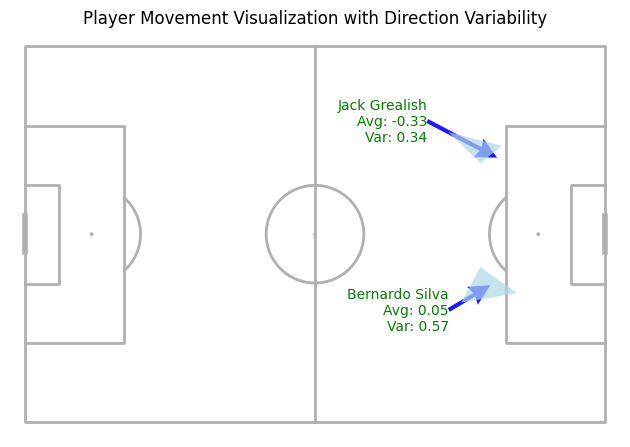

In [80]:
data = player_stats[player_stats.player.isin(['Bernardo Silva', 'Jack Grealish'])].reset_index()

pitch = Pitch(pitch_type='opta', pitch_color='white', linewidth=2)
fig, ax = pitch.draw()

# Loop through the data and plot each player's position and stats
for i in range(len(data['player'])):
    player_name = data['player'][i]
    avg_lateral = data['avg_lateral_movement_per_length'][i]
    var_lateral = data['var_lateral_movement_per_length'][i] if data['var_lateral_movement_per_length'][i] is not None else 0
    start_x = data['avg_start_x'][i]
    start_y = data['avg_start_y'][i]
    end_x = data['avg_end_x'][i]
    end_y = data['avg_end_y'][i]

    # Calculate the direction vector for the average movement
    dx = end_x - start_x
    dy = end_y - start_y

    # Calculate the angle of the average direction
    angle = np.arctan2(dy, dx)

    # Length of the average arrow (scaled for visibility)
    avg_length = np.sqrt(dx**2 + dy**2) * 1.5  # Scale by 1.5 for better visibility

    # Calculate the angle adjustment for the variance (in radians)
    variance_scale = var_lateral * 50  # Scaling factor for better visualization (adjust as needed)

    # Create angles for the fan shape
    left_angle = angle - np.radians(variance_scale)
    right_angle = angle + np.radians(variance_scale)

    # New endpoint for the arrow to match the arrow head
    arrow_head_x = start_x + 0.2 * avg_length * np.cos(angle)
    arrow_head_y = start_y + 0.2 * avg_length * np.sin(angle)

    # Define a fixed width for the fan shape
    fan_width = 10  # Width of the fan shape (adjustable as needed)

    # Determine the fan shape points
    left_fan_point = np.array([
        arrow_head_x + fan_width * np.cos(left_angle),
        arrow_head_y + fan_width * np.sin(left_angle)
    ])
    right_fan_point = np.array([
        arrow_head_x + fan_width * np.cos(right_angle),
        arrow_head_y + fan_width * np.sin(right_angle)
    ])


    # Plot the average movement direction as an arrow with smaller heads
    pitch.arrows(start_x, start_y, end_x, end_y,
                 width=3, headwidth=5, headlength=5, color='blue', alpha=0.9, ax=ax)

    # Create the variance fan as a filled polygon with faint blue color
    fan_polygon = np.array([[arrow_head_x, arrow_head_y], left_fan_point, right_fan_point])
    ax.fill(fan_polygon[:, 0], fan_polygon[:, 1], color='lightblue', alpha=0.7, edgecolor='none')

    # Annotate the player information
    ax.text(start_x, start_y, f"{player_name}\nAvg: {avg_lateral:.2f}\nVar: {var_lateral:.2f}",
            fontsize=10, ha='right', va='center', color='green')

# Set title and show the plot
ax.set_title('Player Movement Visualization with Direction Variability')
plt.show()